In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from os import listdir
from os.path import isfile, join

In [3]:
basepath = os.path.dirname(os.path.abspath('__file__'))
photo_file_path = os.path.join( basepath , 'shipsnet')
json_file_name = 'shipsnet.json'

In [4]:
files_in_folder = [f for f in listdir(photo_file_path) if isfile(join(photo_file_path, f))]

size_mean:10629.9275, size_std:1438.71961808


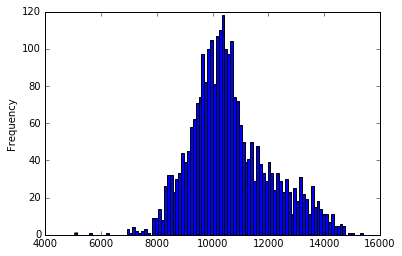

In [5]:
def get_image_dimension(file_path): 
    import matplotlib.pyplot as plt
    img = plt.imread(file_path)
    return img.shape

def get_img_dimension_list(file_path_list, base):
    import os
    width = []
    length = []
    channel = []
    for i in file_path_list:   
        a, b, c = get_image_dimension(os.path.join(base, i))
        width.append(a)
        length.append(b)
        channel.append(c)
    return width, length, channel

def get_image_info(json_file_path): 
    import json
    with open(json_file_path) as data_file:    
        data = json.load(data_file)
    return data

def get_file_type_summary(ext_str_len = 3):
    data_type_summary = {}
    for data in files_in_folder:
        ext = data[-1*ext_str_len:]
        if  ext in data_type_summary.keys():
            data_type_summary[ext] += 1
        else: 
            data_type_summary[ext] = 1
    return data_type_summary

def get_file_size_summary(file_list, file_dir = photo_file_path): 
    import os
    data_summary = { 'file_name': file_list}
    if isinstance( file_list, list): 
        data_summary['file_size'] = [ os.stat(os.path.join(file_dir , i)).st_size for i in file_list]  
        data_summary['extension'] = [ i[-3:] for i in file_list] 
        data_summary['width'], data_summary['length'], data_summary['channel'] = get_img_dimension_list(files_in_folder,photo_file_path)
        return data_summary
    else:
        print('dtype is not a list')
        return None


def data_size_summary(pd_summary):
    data_size = pd_summary['file_size']
    data_size.plot.hist(bins=100)
    size_mean = data_size.mean()
    size_std = data_size.std()
    print( 'size_mean:{}, size_std:{}'.format(size_mean , size_std) )


file_size_summary = get_file_size_summary(files_in_folder)
pd_summary = pd.DataFrame(file_size_summary)
data_size_summary(pd_summary)

In [6]:
img_data = get_image_info(json_file_name)
test_img_path = os.path.join( photo_file_path, files_in_folder[10])

In [7]:
full_data = pd.DataFrame(img_data)[ ['data' , 'labels']]
import sklearn.cross_validation as csvalid
train, test = csvalid.train_test_split(full_data, test_size=0.2, random_state=10) 

In [8]:
def get_data(df):
    import torch
    import torch.utils.data as utils
    data_x = np.array(df['data'].tolist(), dtype=np.float32)
    data_x = torch.from_numpy(data_x.reshape( (-1, 3, 80, 80) ))
    data_y = torch.from_numpy(np.array(df['labels'].tolist(), dtype=np.float32))
    return utils.TensorDataset( data_tensor=data_x, target_tensor=data_y)

In [9]:
train_data = get_data(train)
test_data = get_data(test) 

In [10]:
import torch
from torch.autograd import Variable
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn 
import torch.utils.data as utils
import torch.optim as optim


In [75]:
class Conv2d_Param(): 
    def __init__(self,mini_batch=10, i_channel=3, width=80, height=10, kernel=9): 
        print('This is the conv2d parameter class')
        self.mini_batch = mini_batch
        self.ich = i_channel
        self.width = width
        self.height= height
        self.kernel = kernel

class Net(nn.Module): 
    def __init__(self, param): 
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(param.ich, 3, kernel_size=param.kernel)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=param.kernel)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(588, 14)
        self.fc2 = nn.Linear(14, 10)
        self.fc3 = nn.Linear(10, 1)
              
    def forward(self, x): 
        x = F.relu( F.max_pool2d(self.conv1(x) ,2))
        x = F.relu( F.max_pool2d(self.conv2_drop(self.conv2(x)) ,2))
        x = x.view(-1, 3*14*14)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print('Here1')
        x = F.relu(self.fc2(x))
        #print('Here2')
        x = self.fc3(x)
        #print('Here3')
        return x

    
parameter = Conv2d_Param()
train_loader = utils.DataLoader(train_data,batch_size=4,shuffle=True, num_workers=4)
test_loader = utils.DataLoader(test_data,batch_size=4,shuffle=True, num_workers=4)

This is the conv2d parameter class


In [90]:
model = Net(parameter)

In [91]:
def train(train_loader, model, epoch=10):
    optimzer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.90)
    model.train()
    count = 0
    loss_data = []
    for i in xrange(epoch):
        for batch_id, (datax,target) in enumerate(train_loader):
            x = Variable(datax.float())
            y = Variable((target + 1.0).float())
            optimzer.zero_grad()
            output=model(x)
            loss =F.mse_loss(output, y)
            loss.backward()
            optimzer.step()
            loss_data.append(loss.data[0])
            count += 1
    return loss_data, model

In [ ]:
a, b = train( train_loader , model)

In [ ]:
plt.plot(loss_data)
plt.show()

In [89]:
for d, (dx, dy) in enumerate(test_loader):
    ddx = Variable(dx.float())
    ddy = Variable( (dy +1.0).float())
    output = model(ddx)
    print(output)
    #print( '{}, {}'.format( output, ddy) )

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[torch.FloatTensor of size 4x1]

Variable containing:
 1.2418
 1.2418
 1.2418
 1.2418
[